 # 01 - Geração do dataset com pulmões segmentados (TorchXRayVision)
 
 Este notebook:
 1. Usa um modelo de segmentação do TorchXRayVision para gerar máscaras de pulmão
 2. Combina pulmão direito + esquerdo em uma única máscara
 3. Aplica (opcionalmente) dilatação morfológica à máscara
 4. Cria um novo dataset com imagens "apenas pulmão"
 5. Mostra um comparativo visual (original x sem dilatação x com dilatação)

### Verificação do Ambiente de GPU

In [1]:
!nvidia-smi

Mon Nov 24 21:28:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0            176W /  700W |    7899MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [5] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Verificação de Hardware e Importações

Verifica a disponibilidade CUDA (NVIDIA), exibe o modelo da GPU ativa 

In [4]:
import torch
print("CUDA disponível? ", torch.cuda.is_available())
print("Qtd GPUs: ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU: ", torch.cuda.get_device_name(0))
else:
    # Apple
    print("MPS disponível (Apple Silicon)? ", getattr(torch.backends, "mps", None) and torch.backends.mps.is_available())


CUDA disponível?  True
Qtd GPUs:  1
GPU:  NVIDIA H100 80GB HBM3


### importa a biblioteca `fastai.vision`

In [5]:
from fastai.vision.all import *
print("fastai detectou GPU?:", torch.cuda.is_available())


fastai detectou GPU?: True


### Validação de Leitura de Imagens

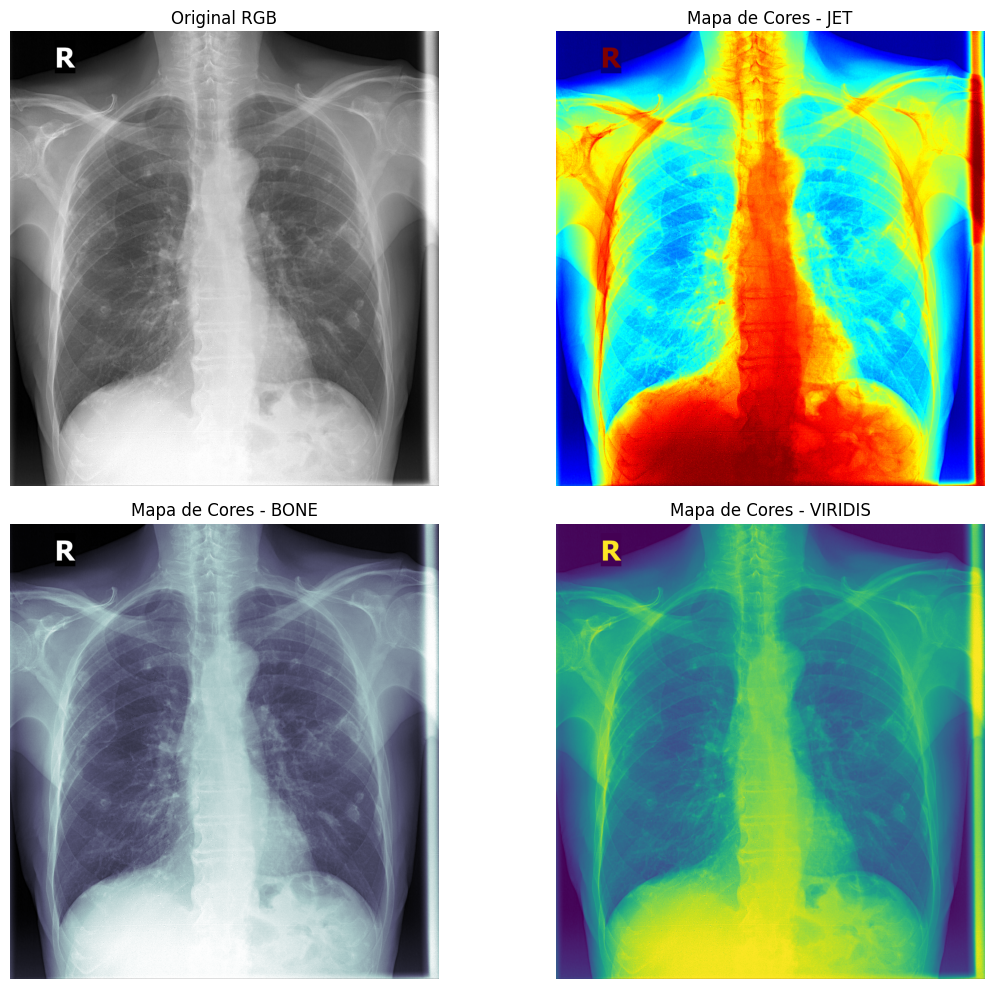

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Caminho da imagem
#imgPath = '/content/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
#imgPath = r'amostra_convertidas/pleural_effusion/101354916913099012081924155376991837012_81ss65.jpg'
imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'


# Carrega imagem BGR e converte para RGB
orig_bgr = cv2.imread(imgPath, cv2.IMREAD_COLOR)
if orig_bgr is None:
    raise FileNotFoundError("Imagem não encontrada.")
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

# Converter para escala de cinza
gray = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2GRAY)

# Aplicar mapas de cor com OpenCV (JET e BONE)
color_jet = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
color_bone = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)
color_viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)

# Converter para RGB (BGR → RGB)
color_jet_rgb = cv2.cvtColor(color_jet, cv2.COLOR_BGR2RGB)
color_bone_rgb = cv2.cvtColor(color_bone, cv2.COLOR_BGR2RGB)
color_viridis_rgb = cv2.cvtColor(color_viridis, cv2.COLOR_BGR2RGB)

# Plotar
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax = axes.ravel()

ax[0].imshow(orig_rgb)
ax[0].set_title("Original RGB")
ax[0].axis('off')

ax[1].imshow(color_jet_rgb)
ax[1].set_title("Mapa de Cores - JET")
ax[1].axis('off')

ax[2].imshow(color_bone_rgb)
ax[2].set_title("Mapa de Cores - BONE")
ax[2].axis('off')

# Usar matplotlib para aplicar viridis
ax[3].imshow(color_viridis_rgb)
ax[3].set_title("Mapa de Cores - VIRIDIS")
ax[3].axis('off')

plt.tight_layout()
plt.show()


## Instalação das dependências

Antes de iniciar o processamento das imagens, é necessário instalar as bibliotecas utilizadas no pipeline de segmentação e manipulação de imagens:

- **TorchXRayVision** — utilizada para carregar o modelo de segmentação pulmonar pré-treinado.
- **scikit-image** — fornece funções de processamento morfológico, como dilatação, erosão e manipulação de máscaras.

O bloco abaixo garante que ambas as dependências estejam instaladas no ambiente do notebook.


In [7]:
!pip install torchxrayvision
!pip install scikit-image

DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 10.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Importação de bibliotecas e configuração de caminhos

Neste bloco são feitas duas etapas fundamentais para o pipeline de geração do dataset segmentado:

1. **Importação das bibliotecas**  
   São carregados os módulos necessários para:
   - Manipulação de caminhos e arquivos: `os`, `pathlib.Path`
   - Operações numéricas: `numpy`
   - Leitura e escrita de imagens: `skimage.io` e `img_as_ubyte`
   - Processamento morfológico (ex.: dilatação): `binary_dilation`, `disk`
   - Redimensionamento de imagens: `resize`
   - Visualização: `matplotlib.pyplot`
   - Deep learning: `torch`, `torchvision.transforms` (como `T`), `torchxrayvision` (modelo de segmentação)
   - Barra de progresso: `tqdm`

2. **Definição e verificação dos caminhos do dataset**
   - `SRC_BASE` define o caminho do **dataset original**, já dividido em `train/val/test`.  
     - Esse valor deve ser ajustado conforme a estrutura do ambiente (há um exemplo comentado para uso em HPC).
   - É feita uma verificação com `assert SRC_BASE.exists()` para garantir que o diretório de origem realmente existe antes de prosseguir.
   - São definidos dois diretórios de saída, criados como “irmãos” do dataset original:
     - `DST_BASE`: armazenará as **imagens recortadas**, contendo apenas a região pulmonar.
     - `MASKS_BASE`: armazenará as **máscaras de pulmão** geradas pelo modelo de segmentação.
   - As variáveis `SPLITS = ["train", "val", "test"]` indicam os subconjuntos esperados do dataset, que serão processados de forma consistente ao longo do notebook.

Esse bloco garante que todas as dependências estejam disponíveis e que a estrutura de diretórios para entrada e saída esteja bem definida antes de iniciar a segmentação das imagens.


In [13]:
# %%
import os
from pathlib import Path

import numpy as np
import skimage.io
from skimage.util import img_as_ubyte
from skimage.morphology import binary_dilation, disk
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torchxrayvision as xrv
from tqdm import tqdm

# %%
# ==========================
# CONFIGURAÇÃO DE CAMINHOS
# ==========================

# Caminho do dataset ORIGINAL já dividido em train/val/test
# Ajuste para o seu caminho real:
# Exemplo HPC:
# SRC_BASE = Path("/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido")
SRC_BASE = Path(r"/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2")  # <<< AJUSTAR AQUI

assert SRC_BASE.exists(), f"Diretório de origem não encontrado: {SRC_BASE}"

# Pastas de saída: vão ser criadas como "irmãs" do dataset original
DST_BASE   = SRC_BASE.parent / f"{SRC_BASE.name}_lungonly"
MASKS_BASE = SRC_BASE.parent / f"{SRC_BASE.name}_lungmasks"

print("Origem:", SRC_BASE)
print("Destino (imagens recortadas):", DST_BASE)
print("Destino (máscaras):", MASKS_BASE)

# Splits esperados
SPLITS = ["train", "val", "test"]

Origem: /lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2
Destino (imagens recortadas): /lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly
Destino (máscaras): /lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungmasks


## Classe de segmentação de pulmões (TorchXRayVision)

Este bloco define a classe `LungSegmenterXRV`, responsável por gerar máscaras de pulmão usando o modelo de segmentação do TorchXRayVision.

### O que a classe faz
- Carrega o modelo **PSPNet** do TorchXRayVision.
- Identifica automaticamente os canais correspondentes aos pulmões.
- Pré-processa a imagem (crop, resize, normalização).
- Gera uma **máscara binária** combinando pulmão direito + esquerdo.
- Aplica **dilatação opcional** na máscara.
- Permite aplicar a máscara diretamente na imagem original.

### Principais métodos

**`_init_lung_indices()`**  
Localiza os índices dos canais que representam pulmões no modelo.

**`_load_xray_for_model(path)`**  
Carrega a imagem, converte para escala de cinza, normaliza e aplica os transforms esperados pelo TorchXRayVision.

**`predict_mask(path, use_dilation=None)`**  
Gera a máscara binária de pulmão.  
- Aplica sigmoid → probabilidade  
- Faz max entre canais de pulmão  
- Converte em máscara booleana  
- (Opcional) aplica dilatação com raio definido

**`apply_mask_to_original(original_img, mask)`**  
Aplica a máscara na imagem original, zerando os pixels fora da região pulmonar.

### Parâmetros importantes
- `img_size`: tamanho para redimensionar as imagens.
- `dilation_radius`: raio da dilatação morfológica.
- `threshold`: limiar para binarizar a máscara.
- `device`: usa GPU se disponível.

esta classe é toda a lógica de **segmentação**, **pós-processamento** e **aplicação da máscara**, para gerar um dataset contendo apenas a área dos pulmões.


In [14]:
# %%
# ==========================
# CLASSE DE SEGMENTAÇÃO
# ==========================

class LungSegmenterXRV:
    """
    Usa o modelo de segmentação do TorchXRayVision (ex.: PSPNet)
    para gerar máscara de pulmão (esquerdo + direito), com opção
    de dilatação morfológica.
    """

    def __init__(
        self,
        device: str | None = None,
        img_size: int = 512,
        dilation_radius: int = 5,
        threshold: float = 0.5,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.img_size = img_size
        self.dilation_radius = dilation_radius
        self.threshold = threshold

        # Modelo de segmentação
        # (se você quiser testar outro modelo de segmentação do xrv, é aqui)
        self.model = xrv.baseline_models.chestx_det.PSPNet()
        self.model.to(self.device)
        self.model.eval()

        # Transforms recomendados pelo xrv (operam em numpy)
        self.transform = T.Compose([
            xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(self.img_size),
        ])

        # Detecta automaticamente quais canais são pulmão
        # (ex.: "left lung", "right lung")
        self._init_lung_indices()

    def _init_lung_indices(self):
        targets = getattr(self.model, "targets", None)
        if targets is None:
            raise RuntimeError("O modelo não possui atributo 'targets' para identificar canais de pulmão.")

        targets_lower = [t.lower() for t in targets]

        # tenta achar todos canais que contenham "lung"
        lung_indices = [i for i, t in enumerate(targets_lower) if "lung" in t]

        if not lung_indices:
            raise RuntimeError(
                f"Não encontrei canais de pulmão em model.targets: {targets}"
            )

        self.lung_indices = lung_indices
        print("Canais de pulmão encontrados (índices):", self.lung_indices)
        print("Targets correspondentes:", [targets[i] for i in self.lung_indices])

    def _load_xray_for_model(self, path: str) -> np.ndarray:
        """
        Carrega a imagem de raio-X em escala de cinza e aplica
        normalização e transforms esperados pelo TorchXRayVision.
        Retorna um numpy array (1, H, W).
        """
        img = skimage.io.imread(path)

        # Normaliza para o range [-1024, 1024] a partir de 0–255
        img = xrv.datasets.normalize(img, 255)

        # Converte para single-channel
        if img.ndim == 3:
            img = img.mean(2)
        img = img[None, ...]  # (1, H, W)

        img = self.transform(img)  # ainda numpy
        return img

    def predict_mask(self, path: str, use_dilation: bool | None = None) -> np.ndarray:
        """
        Retorna máscara binária (H, W) com pulmão = True.
        Se use_dilation=None usa o valor padrão definido em self.dilation_radius.
        """
        img_np = self._load_xray_for_model(path)  # (1, H, W)
        img_t = torch.from_numpy(img_np).float()

        # Garante batch dimension se necessário
        if img_t.ndim == 3:  # (C, H, W) -> (1, C, H, W)
            img_t = img_t.unsqueeze(0)

        img_t = img_t.to(self.device)

        with torch.no_grad():
            pred = self.model(img_t)  # esperado: (1, C, H, W)

        # Seleciona apenas os canais de pulmão e faz max entre eles
        logits_lung = pred[:, self.lung_indices, :, :]   # (1, n_lungs, H, W)
        prob_lung = torch.sigmoid(logits_lung)           # (1, n_lungs, H, W)
        prob_lung_max = prob_lung.max(dim=1).values      # (1, H, W)

        mask_np = prob_lung_max.squeeze().cpu().numpy()
        mask_bin = mask_np > self.threshold

        # Decide se aplica dilatação
        if use_dilation is None:
            dr = self.dilation_radius
        else:
            dr = self.dilation_radius if use_dilation else 0

        if dr > 0:
            selem = disk(dr)
            mask_bin = binary_dilation(mask_bin, selem)

        return mask_bin.astype(bool)

    @staticmethod
    def apply_mask_to_original(original_img: np.ndarray, mask: np.ndarray) -> np.ndarray:
        """
        Aplica a máscara à imagem original:
        - Dentro do pulmão: mantém o pixel original
        - Fora do pulmão: zera (preto)
        """
        if original_img.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Shape da imagem {original_img.shape} diferente do shape da máscara {mask.shape}")

        lung_img = original_img.copy()

        if lung_img.ndim == 3 and lung_img.shape[2] == 3:
            mask_3 = np.repeat(mask[..., None], 3, axis=2)
            lung_img[~mask_3] = 0
        else:
            lung_img[~mask] = 0

        return lung_img

## Função para gerar o dataset segmentado

A função `process_split()` processa um dos splits do dataset (`train`, `val` ou `test`) e gera as novas imagens contendo apenas a região pulmonar.

### O que faz
- Percorre as pastas de cada classe dentro do split.
- Para cada imagem:
  1. Carrega a imagem original.
  2. Gera a máscara de pulmão usando o `segmenter`.
  3. Redimensiona a máscara para o tamanho original da imagem.
  4. Aplica a máscara (apaga tudo fora da região pulmonar).
  5. Salva a imagem resultante.
  6. (Opcional) salva a máscara binária para depuração.

### Parâmetros
- `segmenter`: instância da classe `LungSegmenterXRV`.
- `src_split_dir`: pasta do split original.
- `dst_split_dir`: pasta onde serão salvas as imagens segmentadas.
- `masks_split_dir`: pasta opcional para salvar máscaras.
- `dilation_radius`: permite sobrescrever o raio de dilatação por split (não obrigatório).

### Observações importantes
- A função cria automaticamente as pastas necessárias.
- Procura imagens com extensões `.png`, `.jpg` e `.jpeg`.
- A máscara produzida pelo modelo (ex.: 512×512) é redimensionada para o tamanho exato da imagem original antes de ser aplicada.
- Qualquer erro ao processar uma imagem é exibido, mas o processamento continua.

Em resumo, esta função executa todo o pipeline por split, gerando o dataset final contendo apenas as regiões de pulmão.


In [15]:

# %%
# ==========================
# FUNÇÃO PARA GERAR DATASET
# ==========================

def process_split(
    segmenter: LungSegmenterXRV,
    src_split_dir: Path,
    dst_split_dir: Path,
    masks_split_dir: Path | None = None,
    dilation_radius: int | None = None,
):
    """
    Processa um split (train/val/test):
    - Lê imagens do split original (por classe)
    - Gera máscaras de pulmão
    - Aplica a máscara à imagem original
    - Salva imagem recortada
    - (Opcional) Salva máscara binária como imagem para debug
    """
    dst_split_dir.mkdir(parents=True, exist_ok=True)
    if masks_split_dir is not None:
        masks_split_dir.mkdir(parents=True, exist_ok=True)

    classes = [d for d in src_split_dir.iterdir() if d.is_dir()]
    print(f"Processando split: {src_split_dir.name} | classes: {[c.name for c in classes]}")

    for cls_dir in classes:
        class_name = cls_dir.name

        src_class_dir = cls_dir
        dst_class_dir = dst_split_dir / class_name
        dst_class_dir.mkdir(parents=True, exist_ok=True)

        if masks_split_dir is not None:
            masks_class_dir = masks_split_dir / class_name
            masks_class_dir.mkdir(parents=True, exist_ok=True)
        else:
            masks_class_dir = None

        img_paths = []
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            img_paths.extend(list(src_class_dir.glob(ext)))

        for img_path in tqdm(img_paths, desc=f"{src_split_dir.name} / {class_name}"):
            try:
                # Carrega imagem original (para recortar no tamanho original)
                orig_img = skimage.io.imread(str(img_path))

                # Gera máscara NO TAMANHO DO MODELO (512x512, por ex.)
                mask_model_res = segmenter.predict_mask(str(img_path))

                # Redimensiona máscara para o shape 2D da imagem original
                if mask_model_res.shape != orig_img.shape[:2]:
                    mask_resized = resize(
                        mask_model_res.astype(float),
                        output_shape=orig_img.shape[:2],
                        order=0,
                        preserve_range=True,
                        anti_aliasing=False
                    ) > 0.5
                else:
                    mask_resized = mask_model_res

                # Aplica máscara à imagem original (mantém tons de cinza)
                lung_img = segmenter.apply_mask_to_original(orig_img, mask_resized)

                # Salva imagem recortada
                dst_img_path = dst_class_dir / img_path.name
                skimage.io.imsave(dst_img_path.as_posix(), skimage.img_as_ubyte(lung_img))

                # Salva máscara (opcional)
                if masks_class_dir is not None:
                    dst_mask_path = masks_class_dir / img_path.name
                    skimage.io.imsave(
                        dst_mask_path.as_posix(),
                        skimage.img_as_ubyte(mask_resized.astype(float))
                    )

            except Exception as e:
                print(f"[ERRO] ao processar {img_path}: {e}")

## Execução completa da geração do dataset

Este bloco roda todo o pipeline de segmentação para criar o novo dataset contendo **apenas a região pulmonar**.

### O que faz

1. **Cria o segmentador** (`LungSegmenterXRV`)  
   - Define `img_size=512` (tamanho de entrada do modelo).  
   - Define `dilation_radius=5` para expandir levemente a máscara.  
   - Define `threshold=0.5` para binarizar a probabilidade do modelo.

2. **Percorre os splits** (`train`, `val`, `test`)  
   Para cada split:
   - Localiza a pasta de origem (`SRC_BASE/split`)  
   - Define as pastas de destino para imagens e máscaras  
   - Verifica se o split existe  
   - Chama `process_split()` para gerar as imagens segmentadas

3. **Mensagem final**  
   Ao terminar todos os splits, imprime que a criação do dataset segmentado foi concluída.

### Resultado
Após rodar este bloco, são criadas duas estruturas paralelas ao dataset original:

- `*_lungonly/` → contém as imagens com apenas pulmões  
- `*_lungmasks/` → contém as máscaras binárias (úteis para debug)

produz automaticamente o dataset pronto para ser usado em um pipeline de classificação.


In [16]:

# %%
# ==========================
# RODAR A GERAÇÃO COMPLETA
# ==========================

# Cria o segmentador com um raio de dilatação padrão (para o dataset).
# Isso não impede que a gente gere SEM dilatação para o exemplo visual depois.
segmenter = LungSegmenterXRV(
    img_size=512,
    dilation_radius=5,   # controla o quanto "engrossa" o pulmão
    threshold=0.5,
)

for split in SPLITS:
    src_split_dir  = SRC_BASE  / split
    dst_split_dir  = DST_BASE  / split
    masks_split_dir = MASKS_BASE / split  # ou None, se não quiser salvar máscaras

    if not src_split_dir.exists():
        print(f"[AVISO] Split {split} não encontrado em {src_split_dir}, pulando...")
        continue

    process_split(
        segmenter=segmenter,
        src_split_dir=src_split_dir,
        dst_split_dir=dst_split_dir,
        masks_split_dir=masks_split_dir,
    )

print("✅ Geração do dataset 'lungonly' concluída.")

Canais de pulmão encontrados (índices): [4, 5]
Targets correspondentes: ['Left Lung', 'Right Lung']
Processando split: train | classes: ['Pleural_Thickening', 'Pneumonia', 'Efussion', 'Normal', 'Asbestosis signs', 'Outras_Doencas', 'Atelectasis', 'Fibrosis', 'Effusion']


train / Pneumonia: 100%|██████████| 1770/1770 [1:08:27<00:00,  2.32s/it]
train / Efussion: 0it [00:00, ?it/s]
train / Effusion: 100%|██████████| 929/929 [03:19<00:00,  4.66it/s]


Processando split: val | classes: ['Pleural_Thickening', 'Pneumonia', 'Efussion', 'Normal', 'Asbestosis signs', 'Outras_Doencas', 'Atelectasis', 'Fibrosis', 'Effusion']


val / Pneumonia: 100%|██████████| 820/820 [14:29<00:00,  1.06s/it]
val / Efussion: 0it [00:00, ?it/s]
val / Effusion: 100%|██████████| 318/318 [01:11<00:00,  4.48it/s]


Processando split: test | classes: ['Pleural_Thickening', 'Pneumonia', 'Efussion', 'Normal', 'Asbestosis signs', 'Outras_Doencas', 'Atelectasis', 'Fibrosis', 'Effusion']


test / Pneumonia: 100%|██████████| 496/496 [05:15<00:00,  1.57it/s]
test / Efussion: 0it [00:00, ?it/s]
test / Effusion: 100%|██████████| 189/189 [00:29<00:00,  6.48it/s]

✅ Geração do dataset 'lungonly' concluída.


## Exemplo visual da segmentação (comparação)

Este bloco gera uma visualização comparativa para mostrar o efeito da dilatação na máscara pulmonar e no recorte final da imagem.

### O que é feito

1. **Seleciona uma imagem aleatória** do split `train`:
   - Escolhe uma classe aleatória.
   - Escolhe uma imagem dentro da classe.

2. **Carrega a imagem original** para exibição.

3. **Gera duas máscaras diferentes**:
   - **Sem dilatação** (`use_dilation=False`)
   - **Com dilatação** (`use_dilation=True`)

4. **Redimensiona as máscaras** para o tamanho original da imagem (caso necessário).

5. **Aplica as máscaras**:
   - `lung_no_dil`: imagem recortada sem dilatação  
   - `lung_dil`: imagem recortada com dilatação

6. **Exibe um comparativo em 4 partes**:
   - Imagem original  
   - Máscara sem dilatação  
   - Imagem recortada sem dilatação  
   - Imagem recortada com dilatação  

### Finalidade
verificar visualmente:
- A qualidade da segmentação.
- O impacto da dilatação na cobertura pulmonar.
- A diferença entre o recorte estrito e o recorte expandido.



Classe: Fibrosis
Imagem de exemplo: /lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2/train/Fibrosis/00002722_002.jpg
Canais de pulmão encontrados (índices): [4, 5]
Targets correspondentes: ['Left Lung', 'Right Lung']


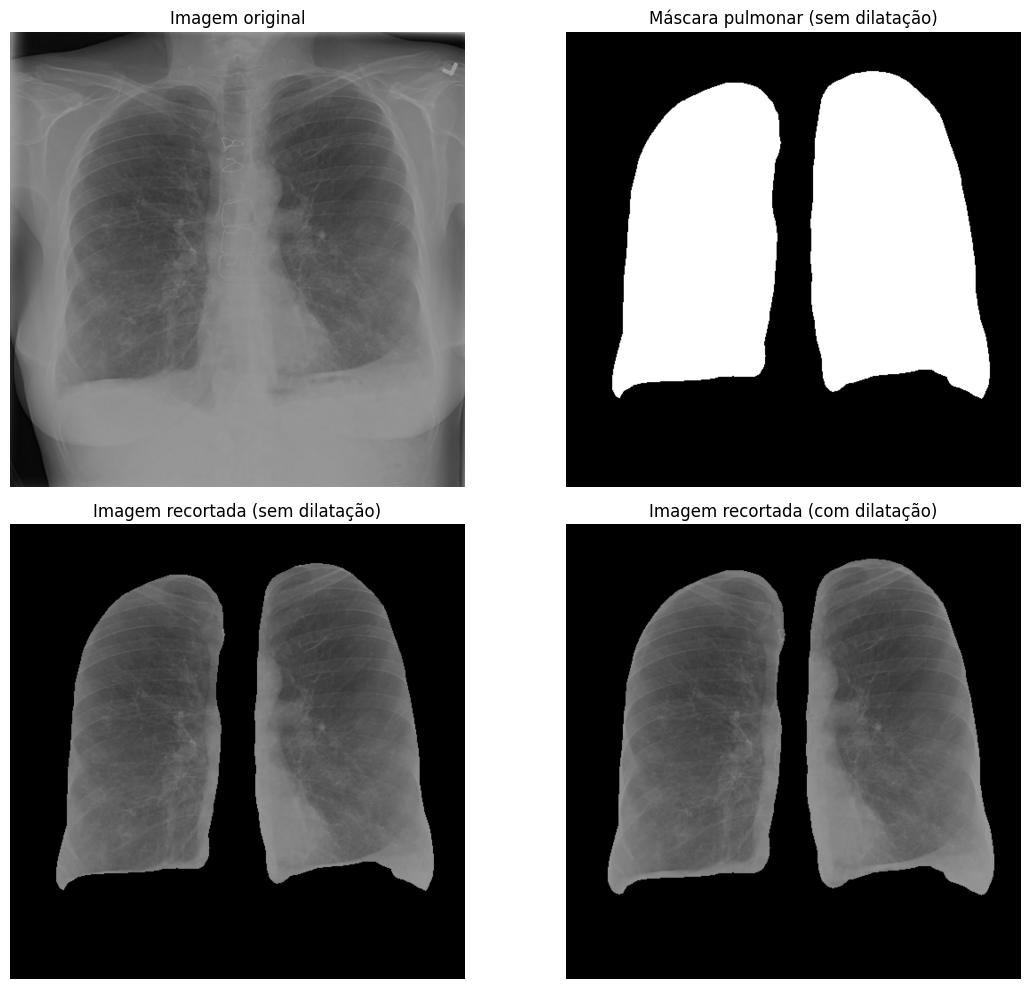

In [17]:
# %%
# ==========================
# EXEMPLO VISUAL (COMPARAÇÃO)
# ==========================
# Vamos pegar uma imagem de exemplo do split de treino
# e comparar:
# - Imagem original
# - Máscara sem dilatação
# - Imagem recortada sem dilatação
# - Imagem recortada com dilatação


import random

# Escolhe uma classe e imagem aleatória do train
train_dir = SRC_BASE / "train"
assert train_dir.exists(), f"Split train não encontrado em {train_dir}"

all_classes = [d for d in train_dir.iterdir() if d.is_dir()]
assert all_classes, f"Nenhuma classe encontrada em {train_dir}"

sample_class_dir = random.choice(all_classes)
sample_imgs = []
for ext in ("*.png", "*.jpg", "*.jpeg"):
    sample_imgs.extend(list(sample_class_dir.glob(ext)))

assert sample_imgs, f"Nenhuma imagem encontrada em {sample_class_dir}"

sample_img_path = random.choice(sample_imgs)
print("Classe:", sample_class_dir.name)
print("Imagem de exemplo:", sample_img_path)

# Carrega imagem original
orig_img = skimage.io.imread(str(sample_img_path))

# Segmentador SEM dilatação (use_dilation=False)
segmenter_no_dil = LungSegmenterXRV(
    img_size=512,
    dilation_radius=5,   # valor não importa, vamos forçar use_dilation=False
    threshold=0.5,
)

mask_no_dil_model = segmenter_no_dil.predict_mask(str(sample_img_path), use_dilation=False)

# Resize da máscara pro tamanho original
if mask_no_dil_model.shape != orig_img.shape[:2]:
    mask_no_dil = resize(
        mask_no_dil_model.astype(float),
        output_shape=orig_img.shape[:2],
        order=0,
        preserve_range=True,
        anti_aliasing=False
    ) > 0.5
else:
    mask_no_dil = mask_no_dil_model

lung_no_dil = segmenter_no_dil.apply_mask_to_original(orig_img, mask_no_dil)

# Segmentador COM dilatação (use_dilation=True)
segmenter_dil = segmenter  # já temos um segmenter com dilation_radius=5
mask_dil_model = segmenter_dil.predict_mask(str(sample_img_path), use_dilation=True)

if mask_dil_model.shape != orig_img.shape[:2]:
    mask_dil = resize(
        mask_dil_model.astype(float),
        output_shape=orig_img.shape[:2],
        order=0,
        preserve_range=True,
        anti_aliasing=False
    ) > 0.5
else:
    mask_dil = mask_dil_model

lung_dil = segmenter_dil.apply_mask_to_original(orig_img, mask_dil)

# %%
# Plot comparativo

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Imagem original
axes[0, 0].imshow(orig_img, cmap="gray")
axes[0, 0].set_title("Imagem original")
axes[0, 0].axis("off")

# 2) Máscara SEM dilatação
axes[0, 1].imshow(mask_no_dil, cmap="gray")
axes[0, 1].set_title("Máscara pulmonar (sem dilatação)")
axes[0, 1].axis("off")

# 3) Imagem recortada SEM dilatação
axes[1, 0].imshow(lung_no_dil, cmap="gray")
axes[1, 0].set_title("Imagem recortada (sem dilatação)")
axes[1, 0].axis("off")

# 4) Imagem recortada COM dilatação
axes[1, 1].imshow(lung_dil, cmap="gray")
axes[1, 1].set_title("Imagem recortada (com dilatação)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()
